In [2]:
# Tratamiento de datos
# ------------------------------------------------------------------------------
import numpy as np
import pandas as pd

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y evaluación
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score , cohen_kappa_score, roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

- Ajustad un modelo de Decision Tree a nuestros datos.

- Calculad las métricas a nuestro nuevo modelo.

- Comparad las métricas con el modelo hecho hasta ahora. ¿Cuál es mejor?

In [4]:
#Cargamos nuestro dataframe, estandarizado, codificado y sin balancear

df_travel_estenc = pd.read_csv("data/df_travel_estenc.csv", index_col=0)
df_travel_estenc.sample(5)

,Claim,Duration,Net Sales,Age,products,agency,country,Commision_oe,Agency Type_oe,Distribution Channel_Offline,Distribution Channel_Online
30532,0,-0.646528,-0.659441,-0.270547,1,2,0,1,1,0.0,1.0
54181,0,-0.646528,-0.553277,1.740567,0,0,0,0,0,0.0,1.0
51377,0,-0.592938,-0.765606,1.338344,1,2,0,1,1,0.0,1.0
36259,0,1.300596,-0.447113,-0.270547,0,0,0,0,0,0.0,1.0
12150,0,3.247721,1.463845,-0.270547,0,0,0,1,1,0.0,1.0


In [5]:
# separamos los datos en X e y

X1 = df_travel_estenc.drop("Claim", axis = 1)
y1 = df_travel_estenc["Claim"]

In [6]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.2, random_state = 42)

In [7]:
# creamos el objeto del modelo, al igual que hacíamos en la regresión lineal
arbol = DecisionTreeClassifier(random_state =0)

# ajustamos el modelo, igual que en la regresión lienal. 
arbol.fit(x_train1, y_train1)

DecisionTreeClassifier(random_state=0)

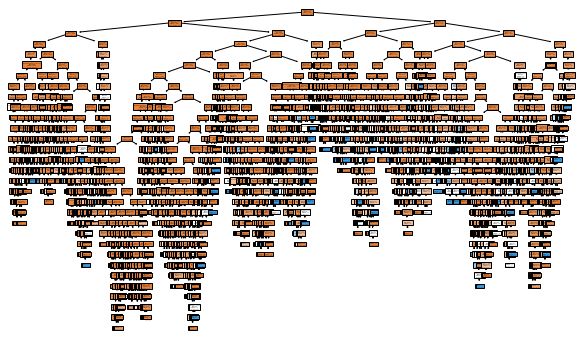

In [8]:
fig = plt.figure(figsize = (10,6))
tree.plot_tree(arbol, feature_names = x_train1.columns.to_list(), filled = True)
plt.show()

In [11]:
# max features. Ponemos en nuestro modelo una profudidad máxima de 10. 

max_features = np.sqrt(len(x_train1.columns))
max_features

3.1622776601683795

In [12]:
# max depth

print(arbol.tree_.max_depth)

30


In [13]:
# hacemos las predicciones sobre los dos set de datos el X_test y el X_train
y_pred_test_esta = arbol.predict(x_test1)
y_pred_train_esta = arbol.predict(x_train1)

In [16]:
def metricas(clases_reales_test, clases_predichas_test, clases_reales_train, clases_predichas_train, modelo):
    
    # para el test
    accuracy_test = accuracy_score(clases_reales_test, clases_predichas_test)
    precision_test = precision_score(clases_reales_test, clases_predichas_test)
    recall_test = recall_score(clases_reales_test, clases_predichas_test)
    f1_test = f1_score(clases_reales_test, clases_predichas_test)
    kappa_test = cohen_kappa_score(clases_reales_test, clases_predichas_test)

    # para el train
    accuracy_train = accuracy_score(clases_reales_train, clases_predichas_train)
    precision_train = precision_score(clases_reales_train, clases_predichas_train)
    recall_train = recall_score(clases_reales_train, clases_predichas_train)
    f1_train = f1_score(clases_reales_train, clases_predichas_train)
    kappa_train = cohen_kappa_score(clases_reales_train, clases_predichas_train)
    

    
    df = pd.DataFrame({"accuracy": [accuracy_test, accuracy_train], 
                       "precision": [precision_test, precision_train],
                       "recall": [recall_test, recall_train], 
                       "f1": [f1_test, f1_train],
                       "kappa": [kappa_test, kappa_train],
                       "set": ["test", "train"]})
    
    df["modelo"] = modelo
    return df

In [17]:
# sacamos las métricas para ver si hay overfitting o unerfitting, para modificar la profundidad en función de estos resultados

dt_results1 = metricas(y_test1, y_pred_test_esta, y_train1, y_pred_train_esta, "Decission Tree Esta I")
dt_results1

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.977984,0.059259,0.051948,0.055363,0.044274,test,Decission Tree Esta I
1,0.995887,1.000000,0.686154,0.813869,0.811862,train,Decission Tree Esta I


Conclusion: claramente hay overfitting viendo los valores de kappa y que los valores del train son mucho mejores que los del test.

Tenemos que reducir la profundidad del modelo

In [18]:
# lo primero que tenemos que hacer es definir un diccionario con los hiperparámetros que queremos modificar y los valores que queremos 

param = {"max_depth": [18, 20, 22, 25, 27], # nuestra profundidad era de 30
        "max_features": [1,2,3,4],# calculamos en celdas anteriores, probaremos a hacer el modelo como una variable, 2, 3 y 4. Ponemos como límite el 4 ya que es el resultado de la raiz cuadrada. 
        # estos dos hiperparámetros son más difíciles de definir, pero usualmente se suelen elegir los siguientes valores
        "min_samples_split": [10, 50, 100],
        "min_samples_leaf": [10,50,100]} 

In [21]:
## una vez creado el diccionario iniciaremos el modelo con GridSearch

gs = GridSearchCV(
            estimator=DecisionTreeClassifier(random_state= 42), # tipo de modelo que queremos hacer
            param_grid= param, # que hiperparámetros queremos que testee
            cv=10, # crossvalidation que aprendimos en la lección de regresión lineal intro. 
            verbose=0) # para que no nos printee ningún mensaje en pantalla

In [22]:
# ajustamos el modelo que acabamos de definir en el GridSearch

gs.fit(x_train1, y_train1)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [18, 20, 22, 25, 27],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_leaf': [10, 50, 100],
                         'min_samples_split': [10, 50, 100]})

In [23]:
# este método nos esta diciendo que el mejor modelo es aquel que tiene 
# una profundidad de 18, que usa 1 variable predictora para construir 
# el modelo y que tiene  un min_samples_leaf y un min_samples_split de 10. 
mejor_modelo = gs.best_estimator_
mejor_modelo

DecisionTreeClassifier(max_depth=18, max_features=1, min_samples_leaf=10,
                       min_samples_split=10, random_state=42)

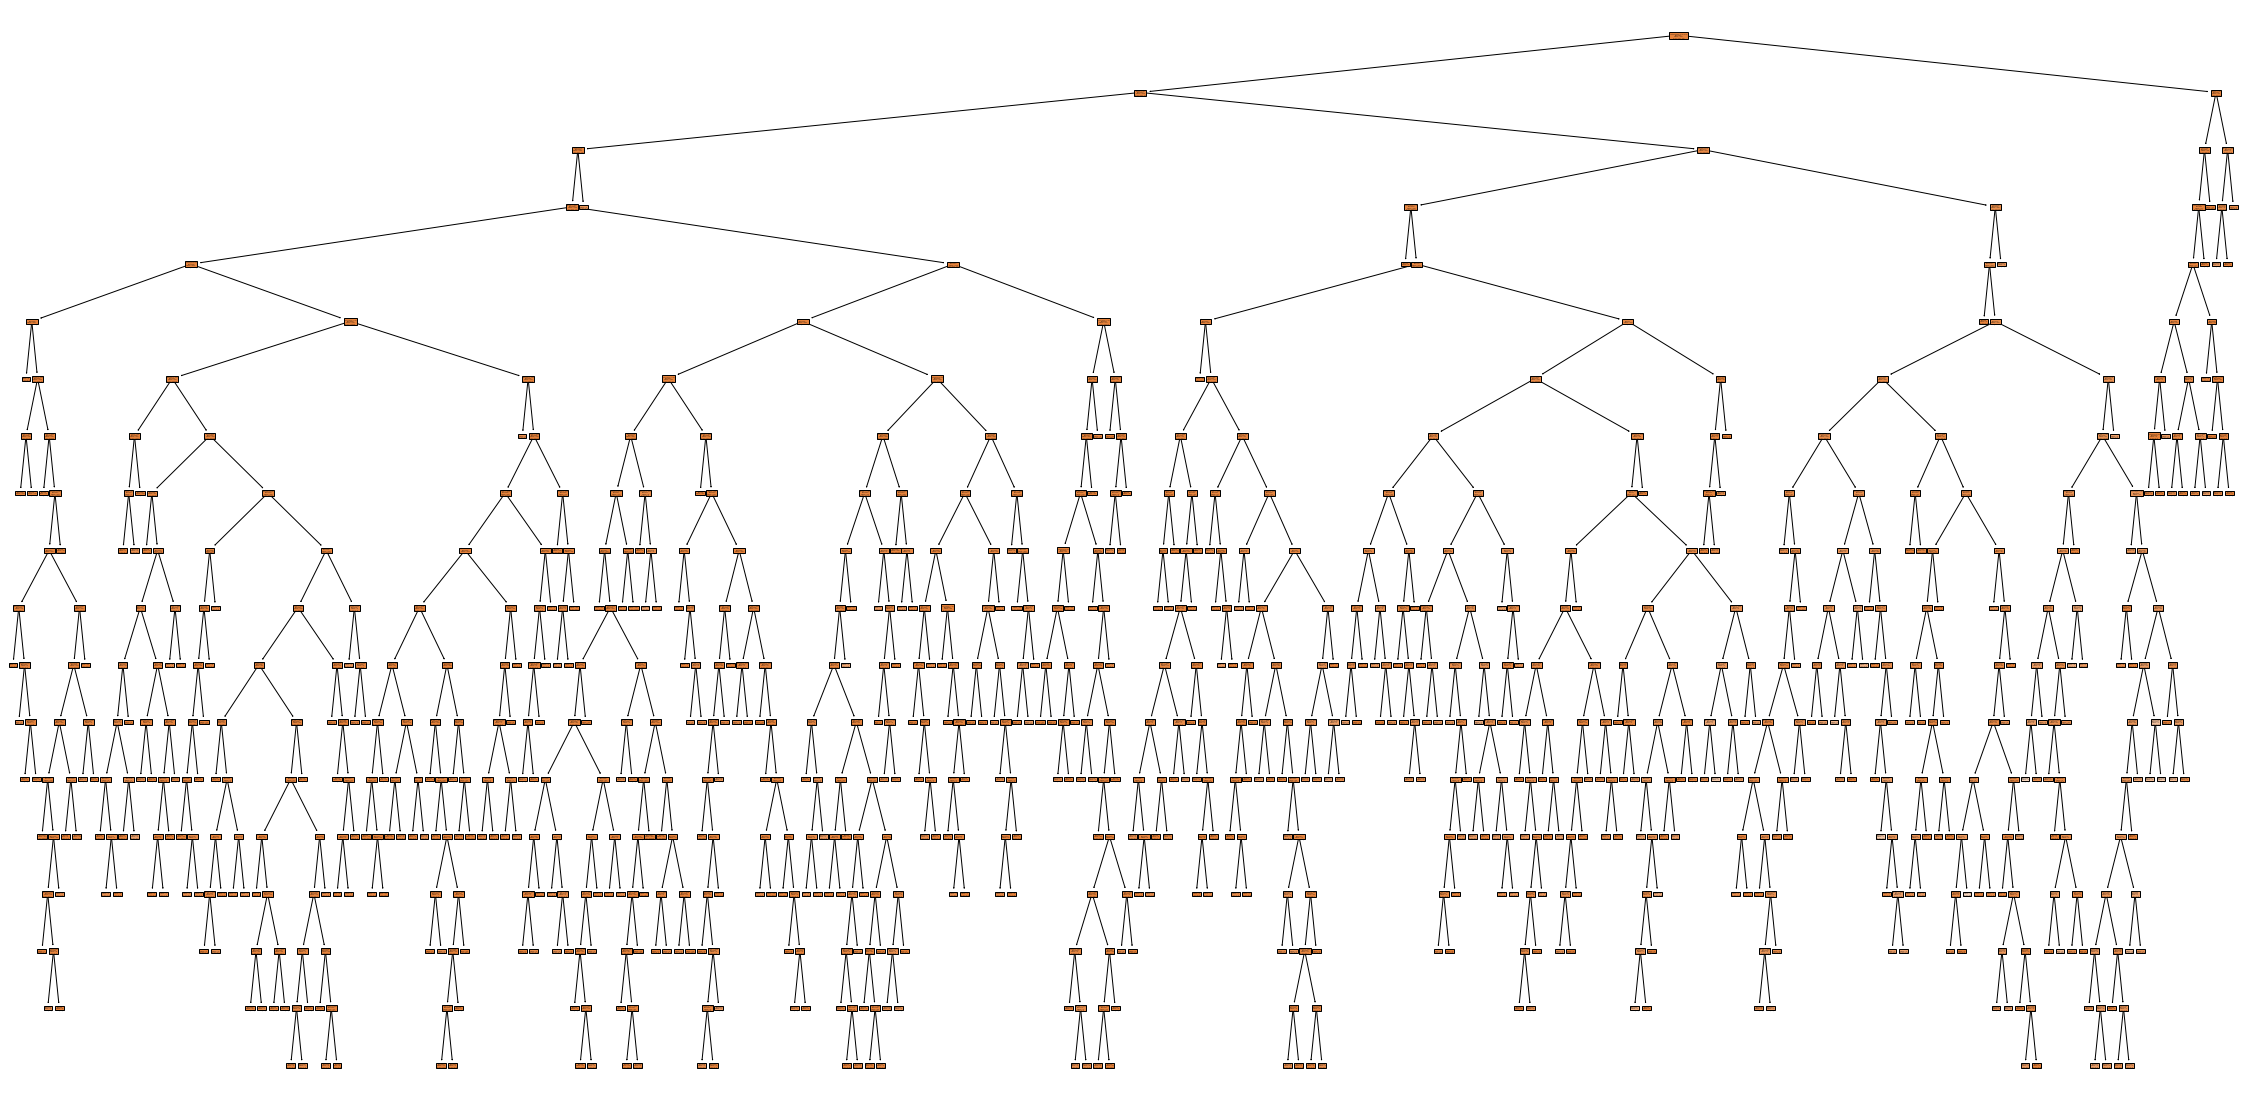

In [25]:
# veamos ahora que pinta tiene nuestro árbol

fig = plt.figure(figsize=(40, 20))
tree.plot_tree(mejor_modelo, feature_names=x_train1.columns.to_list(), filled=True);

In [26]:
#predecimos

y_pred_test_esta2 = mejor_modelo.predict(x_test1)
y_pred_train_esta2 = mejor_modelo.predict(x_train1)

In [27]:
dt_results2 = metricas(y_test1, y_pred_test_esta2, y_train1,  y_pred_train_esta2, "Decision tree Esta II")
dt_results2

,accuracy,precision,recall,f1,kappa,set,modelo
0,0.987581,0.0,0.0,0.0,0.0,test,Decision tree Esta II
1,0.986894,0.0,0.0,0.0,0.0,train,Decision tree Esta II


### faltan las conclusiones 

In [ ]:
# vamos  a juntar los dataframes de los resultados de los modelos para poder compararlos mejor

df_decision_results = pd.concat([dt_results1, dt_results2], axis = 0)
df_decision_results

In [ ]:
# si recodáis, en la clase de métricas guardamos en un csv los resultados de las métricas del modelo
# vamos a cargar ese csv para comparar todos los modelos que hemos hecho, y comparar cuál de ellos es el mejor

df_logistic_results = pd.read_csv("../files/resultados_titanic_logistica.csv", index_col = 0)
df_logistic_results

In [ ]:
# concatenamos todos los resultados

df_DT_LR_results = pd.concat([df_logistic_results, df_decision_results], axis = 0).reset_index(drop=True)
df_DT_LR_results